In [92]:
##Libraries##

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import insert
import pyodbc
import numpy as np
import matplotlib.pyplot as plt




In [93]:
##Connection to cmv_uat database##

server = 'tcp:mycmvserver.database.windows.net' 
database = 'cmvdb_uat' 
username = 'ecervantes@cmvlatam.com' 
password = 'Columbia87/' 


connection = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};Server=tcp:mycmvserver.database.windows.net,1433;Database=cmvdb_uat;Uid='+username+';Pwd='+password+';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;Authentication=ActiveDirectoryInteractive')
cursor = connection.cursor()

In [ ]:
ncliente =  ###### ##Blotter + last 5 trades ### 
query = "SELECT * FROM [dbo].[fxblotter.t]"
# Read the SQL query into a DataFrame
fxblotter = pd.read_sql(query, connection, index_col='tradeid', parse_dates=True)
fxblotter.sort_index(inplace=True)
#datetime format#
fxblotter['tradedate'] = pd.to_datetime(fxblotter['tradedate'])
fxblotter['valuedate'] = pd.to_datetime(fxblotter['valuedate'])
## filtro para numero de cliente en T o dia de consulta ###
fxblottert = fxblotter.loc[fxblotter['clienteid'] == ncliente]
## filtro para accionid, escencialmente deja los Lost deals por fuera del calculo ##
fxblottert = fxblottert[fxblottert['accionid'] == 1] ### acepting 'addnew', 'lost' do not count for spread analysis##

query = "SELECT * FROM [dbo].[cstats]"
# Read the SQL query into a DataFrame
cstatsblotter = pd.read_sql(query, connection, index_col='tradeid', parse_dates=True)
cstatsblotter.sort_index(inplace=True)
#datetime format#
cstatsblotter['tradedate'] = pd.to_datetime(fxblotter['tradedate'])
cstatsblotter['valuedate'] = pd.to_datetime(fxblotter['valuedate'])
## filtro para numero de cliente en T o dia de consulta ###
cstatsblottert = cstatsblotter.loc[cstatsblotter['clienteid'] == ncliente]
ccstatsblottert = cstatsblottert.copy() ## to solve chained assigement error
#won/lost format#
ccstatsblottert.loc[ccstatsblottert['accionid'] == 1, 'accionid'] = 'won'
ccstatsblottert.loc[ccstatsblottert['accionid'] == 4, 'accionid'] = 'lost'
ccstatsblottert.tail(5)

##fxblottert.head(5)

In [95]:
### C-Stats

#forma 1
#filtro por cliente
#sumo todos los colones y todos los dolares, y calculo los dolares a tasa de cover 
bidfxblottert = fxblottert.loc[fxblotter['comccyid'] == 1 ]
askfxblottert = fxblottert.loc[fxblotter['venccyid'] == 1 ] 
#forma 2 
#diff px_sp y px_cover
spreadbidmpp =  bidfxblottert['monex_pp'] - fxblottert['px_sp'] 
spreadaskmpp =  askfxblottert['px_sp'] - fxblottert['monex_pp'] 
bidcount = fxblottert.loc[fxblotter['comccyid'] == 1, 'montocom'].count()
askcount = fxblottert.loc[fxblotter['venccyid'] == 1, 'montoven'].count()
spreadbidpxc =  bidfxblottert['px_cover'] - fxblottert['px_sp'] 
spreadaskpxc =  askfxblottert['px_sp'] - fxblottert['px_cover']
spreadbidpxl =  bidfxblottert['monex_pxlast'] - fxblottert['px_sp'] 
spreadaskpxl =  askfxblottert['px_sp'] - fxblottert['monex_pxlast']
bidmontoavg =  bidfxblottert.loc[fxblotter['comccyid'] == 1, 'montocom'].mean()
askmontoavg = askfxblottert.loc[fxblotter['venccyid'] == 1, 'montoven'].mean( )
bidsum = fxblottert.loc[fxblotter['comccyid'] == 1, 'montocom'].sum()
asksum = fxblottert.loc[fxblotter['venccyid'] == 1, 'montoven'].sum()
##blendedspread = 


print1 ="Bid Spread to Monex P.P :  {:,} CRC"
print(print1.format(round(spreadbidmpp.mean(),3)))
print1 ="Bid Spread to Cover P.P :  {:,} CRC"
print(print1.format(round(spreadbidpxc.mean(),3)))
print1 ="Bid Spread to Monex last traded PX :  {:,} CRC"
print(print1.format(round(spreadbidpxl.mean(),3)))
print1 ="Bid monto promedio por transaccion :  {:,} USD"
print(print1.format(round(bidmontoavg,3)))
print1 ="Bid total millage :  {:,} USD"
print(print1.format(bidsum))
print1 ="Bids traded :  {:,} "
print(print1.format(bidcount))
print("                                         ")
print("************************************************************************************")
print("                                         ")
print1 ="Ask Spread to Monex P.P :  {:,} CRC"
print(print1.format(round(spreadaskmpp.mean(),3)))
print1 ="Ask Spread to Cover P.P :  {:,} CRC"
print(print1.format(round(spreadaskpxc.mean(),3)))
print1 ="Ask Spread to Monex last traded PX :  {:,} CRC"
print(print1.format(round(spreadaskpxl.mean(),3)))
print1 ="Bid monto promedio por transaccion :  {:,} USD"
print(print1.format(round(askmontoavg,3)))
print1 ="Ask total millage :  {:,} USD"
print(print1.format(asksum))
print1 ="Asks :  {:,}"
print(print1.format(askcount))
print("                                         ")
print("************************************************************************************")
print("                                         ")
print(fxblottert['tradedate'].dt.day_name().value_counts())
##Agregar Histograma para este ultimo print
##fxblottert['tradedate'].dt.day_name().value_counts().hist(bins = day_name())

Bid Spread to Monex P.P :  1.366 CRC
Bid Spread to Cover P.P :  1.359 CRC
Bid Spread to Monex last traded PX :  1.371 CRC
Bid monto promedio por transaccion :  3,931.923 USD
Bid total millage :  290,962.29460105306 USD
Bids traded :  74 
                                         
************************************************************************************
                                         
Ask Spread to Monex P.P :  -6.49 CRC
Ask Spread to Cover P.P :  -6.49 CRC
Ask Spread to Monex last traded PX :  -6.49 CRC
Bid monto promedio por transaccion :  7,470.89 USD
Ask total millage :  7,470.89 USD
Asks :  1
                                         
************************************************************************************
                                         
Tuesday      18
Wednesday    17
Thursday     16
Friday       15
Monday        9
Name: tradedate, dtype: int64


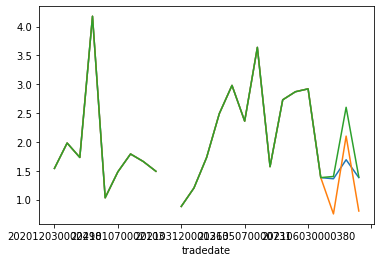

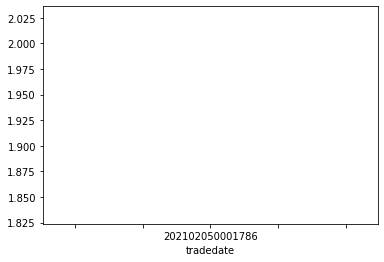

In [189]:
##spread.plot()##
spreadbidmpp.plot.line( label = "spread",xlabel = "tradedate")
spreadbidpxc.plot.line(label = "spread",xlabel = "tradedate")
spreadbidpxl.plot.line(label = "spread",xlabel = "tradedate")
plot.show()


spreadaskmpp.plot.line(label = "spread",xlabel = "tradedate")
spreadaskpxc.plot.line(label = "spread",xlabel = "tradedate")
spreadaskpxl.plot.line(label = "spread",xlabel = "tradedate")
plot.show()

In [ ]:
pip install matplotlib
